In [5]:
import jax.numpy as jnp
import bayes3d as b
import functools
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [6]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7025/static/


In [7]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)

In [8]:
mesh  =b.utils.load_mesh(os.path.join(b.utils.get_assets_dir(), "sample_objs/icosahedron.obj"))
print(mesh.vertices.shape)

(12, 3)


In [56]:
def process_ball(position, quaternion, scaling, opacity):
    S = jnp.eye(3) * scaling
    R = b.quaternion_to_rotation_matrix(quaternion)
    cov3d  = R @ S @ S.transpose() @ R.transpose()
    J = jnp.array([
        [intrinsics.fx / position[2], 0.0, -(intrinsics.fx * position[0]) / (position[2]**2)],   
        [0.0, intrinsics.fx / position[2], -(intrinsics.fy * position[1]) / (position[2]**2)],   
        [0.0, 0.0, 0.0],
    ])
    T = J
    cov2d = (J @ cov3d @ J.transpose())[:2,:2]
    cov2d_inv = jnp.linalg.inv(cov2d)
    cov2ddet = (cov2d[0,0]*cov2d[1,1] - cov2d[0,1]**2)
    ball_xy = position[:2] / position[2] * jnp.array([intrinsics.fx, intrinsics.fy]) + jnp.array([intrinsics.cx, intrinsics.cy]) 
    return (
        jnp.array([cov2d_inv[0,0], cov2d_inv[0,1], cov2d_inv[1,1]]),
        cov2ddet,
        jnp.array([ball_xy[0], ball_xy[1]]),
        position[2],
        opacity,
    )

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,3,4,5,),
)
def get_value_at_pixel(
    ij,
    all_cov,
    all_cov_det,
    all_pixel,
    all_z,
    all_opacity
):
    T = 1.0
    far = intrinsics.far
    running_value = 0.0
    for idx in jnp.arange(all_cov.shape[0]):
        cov_x, cov_y, cov_z = all_cov[idx]
        cov_det = all_cov_det[idx]
        ball_x, ball_y = all_pixel[idx]
        depth_val = all_z[idx]
        opacity = all_opacity[idx]
        d = jnp.array([ball_x, ball_y]) - ij
        power = -0.5 * (cov_x * d[0]**2 + cov_z * d[1]**2 + 2 * cov_y * d[0] * d[1])
        alpha = jnp.minimum(0.99, opacity * jnp.exp(power))
        test_T = T * (1 - alpha)
        alpha_threshold = 1.0/2055.0
        running_value = jnp.where(jnp.logical_or(jnp.logical_or(power > 0.0, alpha < alpha_threshold), T < 0.0001), running_value, running_value + depth_val * alpha * T)
        T = jnp.where(jnp.logical_or(jnp.logical_or(power > 0.0, alpha < 1.0/255.0), T < 0.0001), T, test_T)
    running_value += T * far
    return running_value

def render(positions, quaternions, scalings, opacitys):
    order = jnp.argsort(positions[:,2])
    processed_ball_data = jax.vmap(process_ball)(
        positions[order],
        quaternions[order],
        scalings[order],
        opacitys[order]
    )
    jj, ii = jnp.meshgrid(jnp.arange(intrinsics.width), jnp.arange(intrinsics.height))
    pixel_indices = jnp.stack([jj,ii],axis=-1)

    image = get_value_at_pixel(pixel_indices, *processed_ball_data)
    return image
render_jit = jax.jit(render)

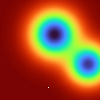

In [58]:
positions = jnp.array([
    [0.1, -0.4, 12.5],
    [1.1, 0.4, 14.6],
])
quaternions = jnp.ones((positions.shape[0], 4))
scalings = jnp.array([
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0],
]) * 0.4
opacitys = jnp.array([1.0, 1.0, 0.5])
image = render_jit(positions, quaternions, scalings, opacitys)
b.get_depth_image(image).convert("RGB")

In [ ]:
shape_model = jax.vmap(lambda x: jnp.array([jnp.cos(x), jnp.sin(x), 0.0]))(jnp.linspace(0.0, 2*jnp.pi, 100)) * 0.1

In [109]:
def render_from_pos_quat(pos,quat):
    image = render(b.apply_transform_jit(shape_model, 
        b.transform_from_rot_and_pos(b.quaternion_to_rotation_matrix(quat), pos)                                         
    ), quaternions, scalings, opacitys)
    return image
render_from_pos_quat_jit = jax.jit(render_from_pos_quat)

def loss(pos,quat, gt_image):
    return jnp.mean((render_from_pos_quat(pos,quat) - gt_image)**2)
value_and_grad_loss = jax.jit(jax.value_and_grad(loss, argnums=(0,1,)))

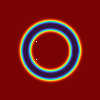

In [110]:
# random_positions = jax.random.uniform(jax.random.PRNGKey(10),(50,3), minval=-1.0, maxval=1.0) * 0.1
N = shape_model.shape[0]
quaternions = jnp.ones((N, 4))
scalings = jnp.ones((N, 3))*0.01
opacitys = jnp.ones(N)

pose = b.transform_from_pos(jnp.array([0.0, 0.0, 2.0]))
pos,quat = pose[:3,3], b.rotation_matrix_to_quaternion(pose[:3,:3])
gt_image = render_from_pos_quat_jit(pos,quat)
b.get_depth_image(gt_image).convert("RGB")

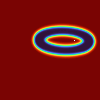

In [287]:
random_pose = b.distributions.gaussian_vmf_jit(
    jax.random.PRNGKey(10),
    pose,
    0.04,
    10.0
)
pos,quat = random_pose[:3,3], b.rotation_matrix_to_quaternion(random_pose[:3,:3])
image = render_from_pos_quat_jit(pos,quat)
b.get_depth_image(image).convert("RGB")

In [288]:
parameters_over_time = []
losses_over_time = []

100%|██████████| 100/100 [00:00<00:00, 161.90it/s]

0.40647972


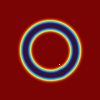

In [289]:
learning_rate_pos = 0.000001
learning_rate_quat = 0.0001
for _ in tqdm(range(100)):
    value, grads = value_and_grad_loss(pos,quat,gt_image)
    pos = pos - grads[0]*learning_rate_pos
    quat = quat - grads[1]*learning_rate_quat
    parameters_over_time.append((pos,quat))
    losses_over_time.append(value)
print(value)
image = render_from_pos_quat_jit(pos,quat)
b.get_depth_image(image).convert("RGB")

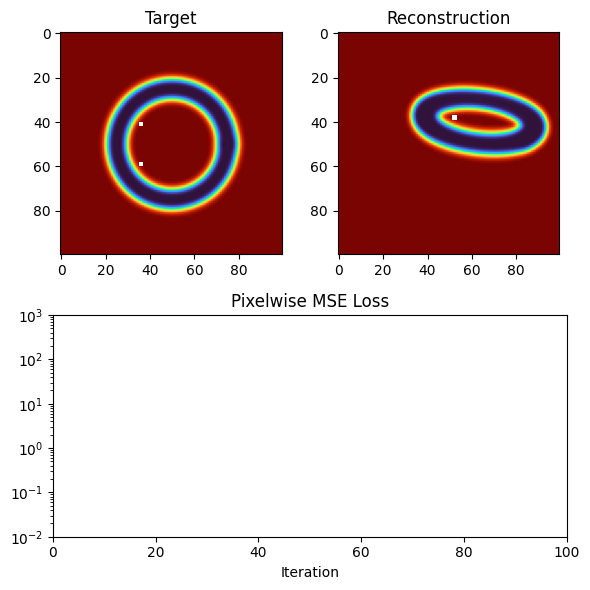

In [303]:
T = 0
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2,2,1)
ax.set_title("Target")
img1 = ax.imshow(b.preprocess_for_viz(gt_image),cmap=b.cmap)
ax = fig.add_subplot(2,2,2)
parameters = parameters_over_time[T]
img2 = ax.imshow(b.preprocess_for_viz(render_from_pos_quat_jit(*parameters)),cmap=b.cmap)
title = ax.set_title(f"Reconstruction")
ax = fig.add_subplot(2,1,2)
line = ax.plot(jnp.arange(T), losses_over_time[:T])
ax.set_yscale("log")
ax.set_title("Pixelwise MSE Loss")
ax.set_ylim(0.01, 1000.0)
ax.set_xlabel("Iteration")
ax.set_xlim(0,len(losses_over_time))
fig.tight_layout()

In [304]:
buffs = []
for T in tqdm(range(0,100,2)):
    parameters = parameters_over_time[T]
    img2.set_array(b.preprocess_for_viz(render_from_pos_quat_jit(*parameters)))
    line[0].set_xdata(jnp.arange(T))
    line[0].set_ydata(losses_over_time[:T])
    fig.canvas.draw()
    buffs.append(b.pil_image_from_matplotlib(fig))

100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


In [305]:
b.make_gif_from_pil_images(buffs, "optimization.gif")

In [238]:
%%time
images = []
for T in range(0, 200, 2):
    parameters = parameters_over_time[T]
    img2.set_array(b.preprocess_for_viz(render_from_pos_quat_jit(*parameters)))
    buff = b.pil_image_from_matplotlib(fig)

CPU times: user 4.92 ms, sys: 49 µs, total: 4.97 ms
Wall time: 3.43 ms


In [189]:
b.make_gif_from_pil_images([
    b.get_depth_image(render_from_pos_quat_jit(*parameters)).convert("RGB")
    for parameters in parameters_over_time[::2]
],"optimization.gif")

In [172]:
grads

(Array([  0.02702332,  -0.3105893 , -18.319511  ], dtype=float32),
 Array([-4.4667969e+00, -3.2282280e+01,  1.1577993e+01, -2.2551537e-02],      dtype=float32))

In [70]:
random_positions

Array([[ 1.0000000e+00,  0.0000000e+00,  2.0000000e+00],
       [ 9.9798667e-01,  6.3423924e-02,  2.0000000e+00],
       [ 9.9195480e-01,  1.2659246e-01,  2.0000000e+00],
       [ 9.8192871e-01,  1.8925124e-01,  2.0000000e+00],
       [ 9.6794868e-01,  2.5114799e-01,  2.0000000e+00],
       [ 9.5007110e-01,  3.1203344e-01,  2.0000000e+00],
       [ 9.2836791e-01,  3.7166247e-01,  2.0000000e+00],
       [ 9.0292656e-01,  4.2979491e-01,  2.0000000e+00],
       [ 8.7384939e-01,  4.8619676e-01,  2.0000000e+00],
       [ 8.4125352e-01,  5.4064083e-01,  2.0000000e+00],
       [ 8.0527025e-01,  5.9290797e-01,  2.0000000e+00],
       [ 7.6604450e-01,  6.4278764e-01,  2.0000000e+00],
       [ 7.2373408e-01,  6.9007903e-01,  2.0000000e+00],
       [ 6.7850941e-01,  7.3459178e-01,  2.0000000e+00],
       [ 6.3055265e-01,  7.7614647e-01,  2.0000000e+00],
       [ 5.8005691e-01,  8.1457597e-01,  2.0000000e+00],
       [ 5.2722543e-01,  8.4972548e-01,  2.0000000e+00],
       [ 4.7227105e-01,  8.8145

In [ ]:

image = get_value_at_pixel(pixel_indices, *processed_ball_data)
b.get_depth_image(image)

In [ ]:
jj, ii = jnp.meshgrid(jnp.arange(intrinsics.width), jnp.arange(intrinsics.height))
ii.shape

In [ ]:
def render_ball(ball_parameters):
    processed_ball_data = jax.vmap(process_ball)(ball_parameters[:3])

    # sorted_processed_ball_data = jax.lax.sort_key_val(processed_ball_data[:,6], processed_ball_data)
    return get_value_at_pixel(pixel_indices, processed_ball_data)

In [ ]:

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,),
)
def get_value_at_pixel(
    ij,
    sorted_processed_ball_data
):
    T = 1.0
    far = intrinsics.far
    running_value = 0.0
    for ball_data in sorted_processed_ball_data:
        cov_x, cov_y, cov_z, cov_det, ball_x, ball_y, depth_val, opacity = ball_data
        d = jnp.array([ball_x, ball_y]) - ij
        
        power = -0.5 * (cov_x * d[0]**2 + cov_z * d[1]**2 + 2 * cov_y * d[0] * d[1])
        alpha = jnp.minimum(0.99, opacity * jnp.exp(power))
        test_T = T * (1 - alpha)

        running_value = jnp.where(jnp.logical_or(jnp.logical_or(power > 0.0, alpha < 1.0/255.0), T < 0.0001), running_value, running_value + depth_val * alpha * T)
        T = jnp.where(jnp.logical_or(jnp.logical_or(power > 0.0, alpha < 1.0/255.0), T < 0.0001), T, test_T)
    running_value += T * far
    return running_value

def process_ball(ball_parameters):
    position = ball_parameters[:3]
    quat = ball_parameters[3:7]
    scaling = ball_parameters[7:10]
    opacity = ball_parameters[10]
    S = jnp.eye(3) * scaling
    R = b.quaternion_to_rotation_matrix(quat)
    cov3d  = R @ S @ S.transpose() @ R.transpose()
    
    J = jnp.array([
        [intrinsics.fx / position[2], 0.0, -(intrinsics.fx * position[0]) / (position[2]**2)],   
        [0.0, intrinsics.fx / position[2], -(intrinsics.fy * position[1]) / (position[2]**2)],   
        [0.0, 0.0, 0.0],
    ])
    T = J
    cov2d = (J @ cov3d @ J.transpose())[:2,:2]
    cov2d_inv = jnp.linalg.inv(cov2d)
    cov2ddet = (cov2d[0,0]*cov2d[1,1] - cov2d[0,1]**2)
    ball_xy = ball_parameters[:2] / ball_parameters[2] * jnp.array([intrinsics.fx, intrinsics.fy]) + jnp.array([intrinsics.cx, intrinsics.cy]) 
    return jnp.array([
        cov2d_inv[0,0], cov2d_inv[0,1], cov2d_inv[1,1],
        cov2ddet,
        ball_xy[0], ball_xy[1],
        position[2],
        opacity,
    ])


def render_ball(ball_parameters):
    processed_ball_data = jax.vmap(process_ball)(ball_parameters)
    jj, ii = jnp.meshgrid(jnp.arange(intrinsics.width), jnp.arange(intrinsics.height))
    pixel_indices = jnp.stack([jj,ii],axis=-1)
    # sorted_processed_ball_data = jax.lax.sort_key_val(processed_ball_data[:,6], processed_ball_data)
    return get_value_at_pixel(pixel_indices, processed_ball_data)

def loss(ball_parameters, gt_depth):
    alphas = render_ball(ball_parameters)
    return ((alphas - gt_depth)**2).mean()
value_and_grad_loss = jax.jit(jax.value_and_grad(loss))


def unproject_depth(depth, intrinsics):
    y, x = jnp.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = jnp.stack([x, y, jnp.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [ ]:
# gt_ball_parameters = jnp.array([
#     [0.1, 0.1, 0.5, 1.0, 1.0, 1.0, 0.0, 0.1, 0.3, 0.2, 1.0],
#     [0.0, 0.0, 0.6, 1.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 1.0],
#     [-1.0, 1.0, 2.5, 1.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.4, 1.0],
#     [-1.0, 1.0, 2.5, 1.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.4, 1.0],
#     [-1.0, 4.0, 5.5, 1.0, 0.0, 0.0, 0.0, 0.3, 0.2, 0.4, 1.0],
# ])
# gt_alphas = render_ball(gt_ball_parameters)
# b.get_depth_image(gt_alphas)

In [ ]:
b.get_depth_image(gt_depth,min=0.0,max=intrinsics.far)

In [ ]:
ball_parameters = jnp.array([
    [0.0, 0.0, 0.2, 1.0, 0.0, 0.0, 0.0, 0.012, 0.002, 0.002, 0.2],
    [0.0, 0.1, 0.4, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 0.3],
    [0.1, 0.1, 0.5, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
    [0.0, 0.1, 0.6, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
    [0.1, 0.1, 0.7, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
    [0.1, 0.1, 0.8, 1.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.002, 1.0],
])
alphas = render_ball(ball_parameters)
b.get_depth_image(alphas)

In [ ]:
pbar = tqdm(range(2000))
for _ in pbar:
    loss_val, gradient_quat = value_and_grad_loss(ball_parameters, gt_depth)
    pbar.set_description("Processing %f" % loss_val.item())
    ball_parameters -= gradient_quat * 0.005
alphas = render_ball(ball_parameters)
b.get_depth_image(alphas,min=0.0,max=intrinsics.far)

In [ ]:
alphas = render_ball(ball_parameters)
b.clear()
b.show_cloud("1", unproject_depth(alphas, intrinsics).reshape(-1,3))
b.show_cloud("gt", unproject_depth(gt_depth, intrinsics).reshape(-1,3), color=b.RED)
b.get_depth_image(alphas,min=0.0,max=intrinsics.far)

In [ ]:
plt.plot(ball_parameters[:,-1])

In [ ]:
b.get_depth_image(render_ball(ball_parameters[2:]),min=0.0,max=intrinsics.far)

In [ ]:
plt.matshow(alphas)
plt.colorbar()

In [ ]:
plt.matshow(gt_depth)
plt.colorbar()